$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\Yv}{\mathbf{Y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\ev}{\mathbf{e}}
\newcommand{\Ev}{\mathbf{E}}
\newcommand{\Rv}{\mathbb{R}}
\newcommand{\Av}{\mathbf{A}}
\newcommand{\vv}{\mathbf{v}}
\newcommand{\Iv}{\mathbf{I}}
\newcommand{\fv}{\mathbf{f}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 1: Stochastic Gradient Descent for Simple Models

Lucas Wilson

## Overview

In this assignment, we learned how to use Jupyter, Numpy and some multidimensional calculus used to solve min-max problems. 

SGD works by assuming the error function is smooth with respect to its parameters. Then, creating a good model depends on our ability to minimize the error function with respect to those parameters. Since we assume it's smooth, the gradient tells us how tuning the parameters will increase or decrease the error. Since want to minimize the error, we move the parameters in the direction which has a negative gradient. Then, the error decreases.

I use the following definitions:

1. For $\xv\in\Rv^n$, $\big[\xv\big]_i$ is the $i^\text{th}$ entry of the vector $\xv$.
1. For $\xv\in\Rv^n$, I define $diag$ in the following way:

    $$
    \big[diag(\xv)\big]_{ij} = 
    \begin{cases} 
          x_i & i = j \\
          0 & i \ne j \\
    \end{cases}.
    $$

    In other words, the entries of the vector are along the diagonal of the diagonal matrix.

1. $\nabla \fv(\xv) = \nabla_\xv \fv = \frac{\partial \fv(\xv)}{\partial \xv}$ is the gradient of the vector $\fv$ where $\fv:\Rv^m\rightarrow\Rv^n$ and $x \in \Rv^m$. In other words, the Jacobian matrix of $\fv$.
1. Standard functions, like $\tanh$, acting on vectors are distributed to each individual entry of the vector. In other words, $\big[\tanh(\xv)\big]_i = \tanh(x_i)$.
1. Notice then that the jacobian of such a function is a diagonal matrix.

    $$
    \nabla_\xv \fv = diag\big(f'(\xv)\big)
    $$

1. A component wise vector product $\wv\Xv = diag(\wv)\times\Xv$. Assume matrix multiplication unless otherwise stated.
1. The linear model is affine and not linear. Inputs have a 1 appended to the end of each sample to simulate bias.
1. The math I use to derive the weights gradient applies to batching the SGD formula. It's more general and allows me to reuse it later. The same formula can be used for each individual sample meaning the $\Xv$ matrix is actual a row vector (matrix in numpy) containing the sample.

The typical steps for this kind of modeling is (1) to find and define a model, (2) define the error function, (3) find the derivatives of the error function with respect to the parameters of the model, (4) update the parameters accordingly to reduce the error. In this case, (4) is SGD, explained below.

## Linear Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

It's especially obvious after the $\tanh$ gradient derivation, but we can generalize the gradient to the following:

$$
\nabla_{\wv_k} E(X) = -2\big(\frac{\partial}{\partial \wv_k} \fv(\Xv; \wv_k)\big)^T (\Tv-\Yv)
$$

Therefore, we can write a general training function which takes the gradient and model as a parameter. That is what the following function does:

In [2]:
def train_model(X, T, learning_rate, n_epochs, use_modelf, gradientf):
    """
    * `X` is a two-dimensional matrix (`np.array`) with each row containing one data sample
    * `T` is a two-dimensional matrix of one column containing the target values for each sample in `X`. `X.shape[0]` is equal to `T.shape[0]`
    * `learning_rate` is the factor multiplying the negative derivative
    * `n_epochs` is the number of update steps to take
    * `use_modelf` is the model
    * `gradientf` is the gradient of the model, not the error.
    * `model` is the two-dimensional matrix of one column containing the resulting weights
    * `error_trace` is the RMSE for each epoch
    """
    # First, we need to add the bias
    Xbias = np.insert(X, 0, 1, axis=1)
    
    # Second, we initialize the model with weights.
    model = np.zeros((Xbias.shape[1], 1))
    #model = np.random.rand(Xbias.shape[1], 1)
    
    # Third, we iterate n_epochs number of times.
    error_trace = []
    for _ in range(n_epochs):
        
        # In each epoch, we iterate through every sample and update the weights for each sample. (not batching)
        for i in range(len(Xbias)):
            
            # We get the the sample as a matrix with 1 row.
            x = Xbias[i:i+1, :]
            t = T[i:i+1, :]
            
            # We apply the model to get the estimation.
            y = use_modelf(model, x[0:1, 1:]) # w/o bias
            
            # We get the gradient of the model.
            model_gradient = gradientf(x, y, model, use_modelf)
            
            # We get the gradient of the error given the gradient of the model
            gradient = model_gradient.T@(t-y)
            
            # With the gradient, we update our weights.
            model += learning_rate*gradient
        
        # Calculate full data approximation
        Y = use_modelf(model, X)
        
        # Calculate RMSE
        RMSE = rmse(Y, T)
        
        # Record RMSE
        error_trace.append(RMSE)
    
    # Return model with epoch RMSEs.
    return model, error_trace

Then, to implement the `train_linear` function, we first define the gradient function, which we found to be $\Xv$. We then pass that to the `train_model` function.

In [3]:
def train_linear(X, T, learning_rate, n_epochs):
    def gradientf(X, Y, model, use_modelf):
        """Gradient of the model not of the error"""
        return X
    return train_model(X, T, learning_rate, n_epochs, use_linear, gradientf)

def use_linear(model, X):
    """
    * `X` is a two-dimensional matrix (`np.array`) with each row containing one data sample
    * `model` is the result of a call to `train_linear`
    * `predict` is a two-dimensional matrix of one column containing the predicted values for each value in `T`
    """
    X = np.insert(X, 0, 1, axis=1)
    return X@model

In [4]:
def rmse(predict, T):
    """ 
    * `T` is a two-dimensional matrix of one column containing the target values for each sample in `X`
    * `predict` is the result of a call to `use_linear(model, X)`
    * `error` is the square root of the mean of the squared error between `predict` and `T`
    """
    return np.sqrt(np.mean((predict-T)**2))

Here is the example code to show you that I get the same results, but I do more testing and explanations further down (in conjunction with tanh)

0.2631104380467893


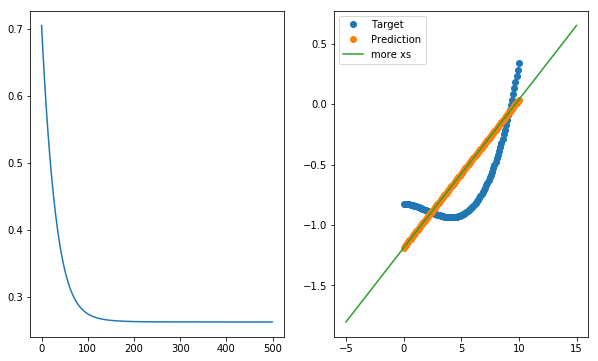

In [5]:
n_samples = 100
X = np.linspace(0, 10, n_samples).reshape((-1, 1))
T = 0.2 - 0.03 * X + np.random.normal(0, 0.05, (n_samples, 1)) + 0.01 * (X - 8)**3
T = -0.8 - 0.04 * X  + 0.003 * (X - 2)**3
w, error_trace = train_linear(X, T, 0.001, 500)
print(rmse(use_linear(w, X), T))
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(error_trace)

plt.subplot(1, 2, 2)
plt.plot(X, T, 'o', label='Target')
plt.plot(X, use_linear(w, X), 'o', label='Prediction')
more_xs = np.linspace(-5, 15, 100).reshape((-1, 1))
plt.plot(more_xs, use_linear(w, more_xs), label='more xs')
plt.legend();

## Tanh Model

Similar to before, we have $\Yv(\Xv) = \tanh(\Xv \wv)$, where $\tanh(\xv)_i = \tanh(\xv_i) $. We define our error to be $E(\Xv) = \norm{\Tv-\Yv}^2_2$. 
Then, to perform stochastic gradient descent, we initialize $\wv$ randomly and update it with the following:

$\wv_{k+1} = \wv_k - \eta \nabla_{\wv_k} E(X)$

$$
\begin{align*}
\nabla_{\wv_k} E(X) &= \frac{\partial E}{\partial \wv_k} \\
&= \frac{\partial}{\partial \wv_k} \norm{\Tv-\Yv}^2_2 \\
&= \sum_i \frac{\partial}{\partial \wv_k} (\Tv-\Yv)^2_i \\
&= \sum_i -2(\Tv-\Yv)_i \frac{\partial \Yv_i}{\partial \wv_k}  \\
&= \sum_i -2(\Tv-\Yv)_i \frac{\partial}{\partial \wv_k} \tanh(\Xv \wv_k)_i \\
&= \sum_i -2(\Tv-\Yv)_i (\frac{\partial}{\partial \wv_k} \tanh(\Xv \wv_k))_i &\text{(since partials distribute across vectors)} \\
&= -2 \big(\frac{\partial}{\partial \wv_k} \tanh(\Xv \wv_k)\big)^T (\Tv-\Yv) &\text{(by definition of dot product (see linear model).)} \\
\end{align*}
$$

Now, we need to know what $\frac{\partial}{\partial \wv_k} \tanh(\Xv \wv_k)$ is.

$$
\begin{align*}
\frac{\partial}{\partial \wv_k} \tanh(\Xv \wv_k) &= \big[\frac{\partial}{\partial (\Xv\wv_k)}\tanh(\Xv \wv_k)\big] \big[\frac{\partial }{\partial \wv_k}\Xv\wv_k\big] \\
&= \big[\frac{\partial}{\partial (\Xv\wv_k)}\tanh(\Xv \wv_k)\big] \Xv & \text{(since } \frac{\partial}{\partial \xv} \Av \xv=\Av \text{)} \\
&= \big[\frac{\partial}{\partial \vv}\tanh(\vv)\big] \Xv &\text{(where } \vv \text{ is a column vector)} \\
\end{align*}
$$

$\tanh: \Rv^n \rightarrow \Rv^n$ and $\tanh_i$ depends only on $\vv_i$, $\big[\tanh(\vv)\big]_i = \tanh(\vv_i)$, so it follows that
$$\begin{align*}
\frac{\partial}{\partial \vv}\tanh(\vv) &= \frac{\partial}{\partial \vv}\frac{\sinh(\vv)}{\cosh(\vv)} \\
&= \frac{\sinh'\cosh - \sinh\cosh'}{\cosh^2} \\
&= \frac{\cosh^2 - \sinh^2}{\cosh^2} \\
&= \frac{\cosh^2}{\cosh^2} - \frac{\sinh^2}{\cosh^2} \\
&= \mathbf{1} - \frac{\sinh^2}{\cosh^2} & \text{(where }\mathbf{1}\text{ is a vector of $1$'s)}\\
&= \Iv-diag\big(\tanh(\vv)\big)^2
\end{align*}
$$.

See definitions 3-5 for a better explanation of these definitions I am using.

Then,
$$
\begin{align*}
\frac{\partial}{\partial \wv_k} \tanh(\Xv \wv_k) &= \Big(\Iv - diag\big(\tanh(\Xv \wv_k)\big)^2 \Big)\Xv \\
&= \big(\Iv - diag(\Yv)^2 \big)\Xv \\
\end{align*}
$$

Then,
$$
\begin{align*}
\nabla_{\wv_k} E(X) &= -2 \big(\frac{\partial}{\partial \wv_k} \tanh(\Xv \wv_k)\big)^T (\Tv-\Yv) \\
&= -2 \Big(\big(\Iv - diag(\Yv)^2 \big)\Xv\Big)^T (\Tv-\Yv) \\
\end{align*}
$$

Again, since $\eta>0$ is arbitrary, the $\wv$ update simplifies to the following:

$$
\wv_{k+1} = \wv_k + \eta \Big(\big(\Iv - diag(\Yv)^2 \big)\Xv\Big)^T (\Tv-\Yv)
$$

Implemented in python, this is much easier to understand:

    w = w + eta * ( (1-Y*Y)*X ).T @ (T-Y)

Instead of creating a diagonal matrix and doing matrix multiplication, we just do piecewise multiplication instead.

And again, this is for batching. We can just define a batch to be a single sample to get what is required by the assignment.

In [6]:
def train_tanh(X, T,learning_rate, number_of_iterations):
    def gradientf(X, Y, model, use_modelf):
        return (1-Y*Y)*X
        #return (1-Y*Y)@X
    return train_model(X, T, learning_rate, number_of_iterations, use_tanh, gradientf)

def use_tanh(model, X):
    X = np.insert(X, 0, 1, axis=1)
    return np.tanh(X@model)

Again, here is the output from the given code:

0.15179499396092516


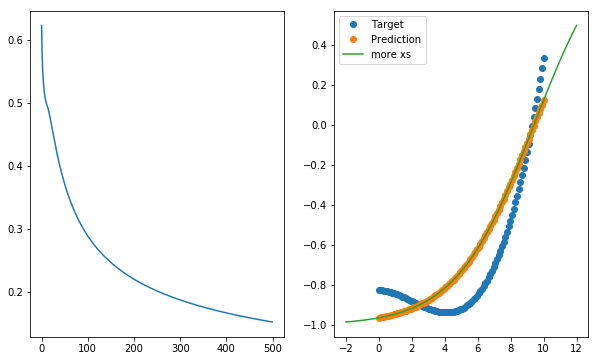

In [7]:
n_samples = 100
X = np.linspace(0, 10, n_samples).reshape((-1, 1))
T = 0.2 - 0.03 * X + np.random.normal(0, 0.05, (n_samples, 1)) + 0.01 * (X - 8)**3
T = -0.8 - 0.04 * X  + 0.003 * (X - 2)**3
w, error_trace = train_tanh(X, T, 0.001, 500)
print(rmse(use_tanh(w, X), T))
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(error_trace)

plt.subplot(1, 2, 2)
plt.plot(X, T, 'o', label='Target')
plt.plot(X, use_tanh(w, X), 'o', label='Prediction')
more_xs = np.linspace(-2, 12, 100).reshape((-1, 1))
plt.plot(more_xs, use_tanh(w, more_xs), label='more xs')
plt.legend();

## Testing

I created a testing function to demonstrate what's happening with the models. It shows the error trace, the data fed to it, the linear model and the tanh model. I can have a third model too (for the extra credit). 

I had to come up with a way for it to graph multidimensional plots (where $X \in \Rv^n$ where $n$ can be any positive integer). I can't have a single dimension along the bottom, so I decided to have the indexes be along the bottom. For evenly spaced X inputs, this will look fine, but it gets a little less coherent otherwise.

Comment: Sometimes when I run this, the RSME dips and then rises. This doesn't contradict the fact that SGD is minimizing the error function because RSME is slightly different from the error function we use to derive our gradient. Therefore, while the squared sum error minimizes, the root squared mean error doesn't necessarily.

In [8]:
def test(title, X, T, linear_model=None, tanh_model=None,
         other_model=None, other_use=None, other_label=None,
         eta=0.01, trials=500, give_models=False):
    
    # model training / unpacking
    linear_model, linear_error = train_linear(X, T, eta, trials) if linear_model is None else linear_model
    tanh_model, tanh_error = train_tanh(X, T, eta, trials) if tanh_model is None else tanh_model
    other_model, other_error = (None, None) if other_model is None else other_model
    
    linear_Y = use_linear(linear_model, X)
    linear_label = 'linear (rmse: {:.3f})'.format(rmse(linear_Y, T))
    tanh_Y = use_tanh(tanh_model, X)
    tanh_label='tanh (rmse: {:.3f})'.format(rmse(tanh_Y, T))
    total = 2
    if other_model is not None:
        other_Y = other_use(other_model, X)
        other_label='{} (rmse: {:.3f})'.format(other_label, rmse(other_Y, T))
        total += 1
    
    # plotting
    plt.figure(figsize=(5*total, 5))
    plt.subplot(1, total, 1)
    plt.ylabel(title)
    plt.plot(linear_error, 'b-', label='linear error')
    plt.plot(tanh_error, 'g-', label='tanh error')
    if other_model is not None:
        plt.plot(other_error, 'r-', label=other_label)
    plt.legend()
    
    plt.subplot(1, total, 2)
    plt.plot(T, 'o', label='actual')
    plt.plot(linear_Y, 'b', label=linear_label)
    plt.plot(tanh_Y, 'g', label=tanh_label)
    if other_model is not None:
        plt.plot(other_Y, 'r', label=other_label)
    plt.legend()
    
    plt.tight_layout()
    
    if give_models:
        return (linear_model, linear_error), (tanh_model, tanh_error), (other_model, other_error)

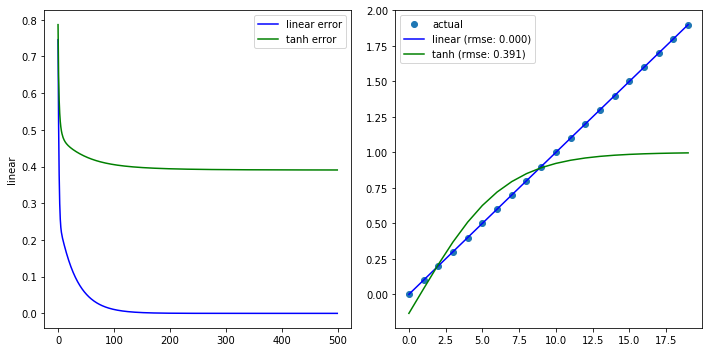

In [9]:
X = (np.arange(20) * 0.1).reshape((-1,1))
test('linear', X, X)

The linear model is capable of fitting linear data, go figure. The tanh is at least on track.

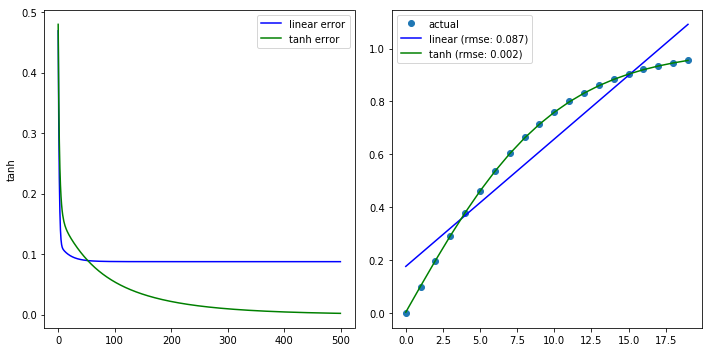

In [10]:
X = (np.arange(20) * 0.1).reshape((-1,1))
test('tanh', X, np.tanh(X))

The tanh model likewise fits a tanh curve

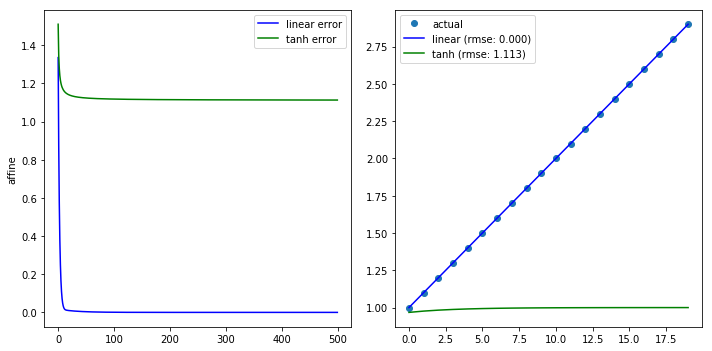

In [11]:
X = (np.arange(20) * 0.1).reshape((-1,1))
test('affine', X, X+1)

This function is affine, not linear. Our linear model is adapted to be affine with the bias, so this confirms that it can still fit it well, and it does. Tanh doesn't do too well, but this makes sense since it's range is $\tanh(\Rv)=[-1, 1]$, so it isn't capable of fitting this data.

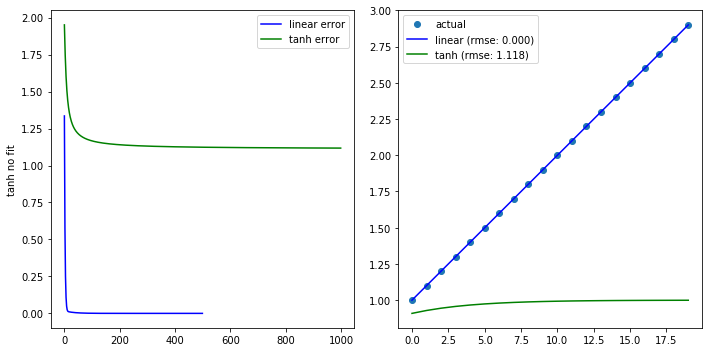

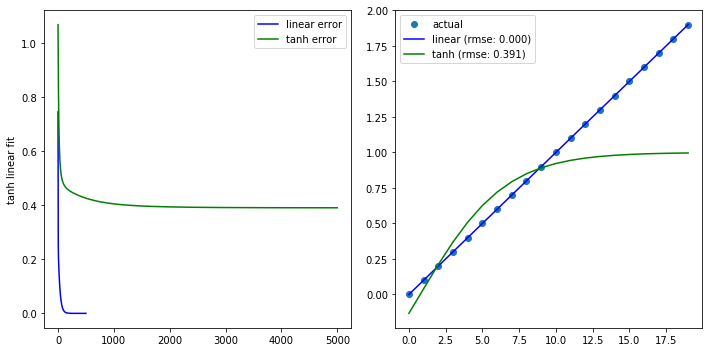

In [12]:
X = (np.arange(20) * 0.1).reshape((-1,1))
tanh_model_gto = train_tanh(X, X+1, 0.001, 1000)
tanh_model = train_tanh(X, X, 0.001, 5000)
test('tanh no fit', X, X+1, tanh_model=tanh_model_gto)
test('tanh linear fit', X, X, tanh_model=tanh_model)

The 'tanh no fit' set won't work because of tanh's range. Instead the model maximizes its outputs to be as close to the data as possible. With the second graph, it's interesting to see that even with excessive training, the tanh model can't fit linear very well. This is probably because it is composed of exponential functions which are of a very different order of magnitude. 

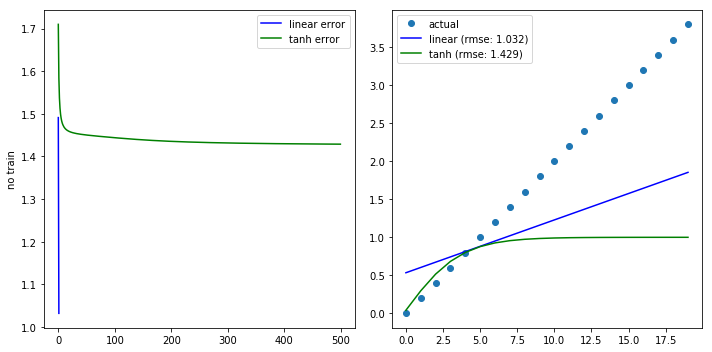

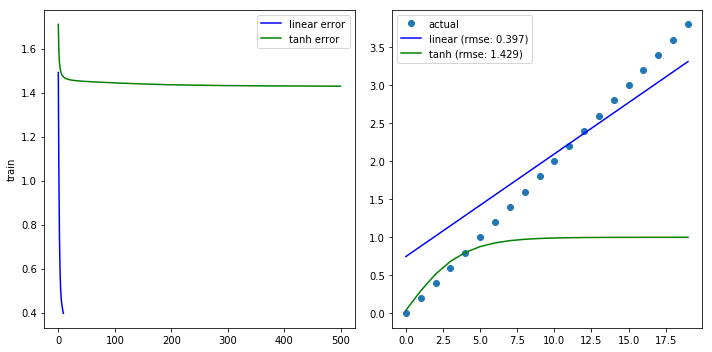

In [13]:
X = (np.arange(20) * 0.1).reshape((-1,1))
T = 2*X

no_train = train_linear(X, T, 0.01, 2)
train = train_linear(X, T, 0.01, 10)
test('no train', X, T, linear_model=no_train)
test('train', X, T, linear_model=train)

You can see from the graphs and rmse that with less training of the model (top graphs) is worse. Of course, this is obvious, but it shows my trainers are working. You can also tell by the decreasing error function

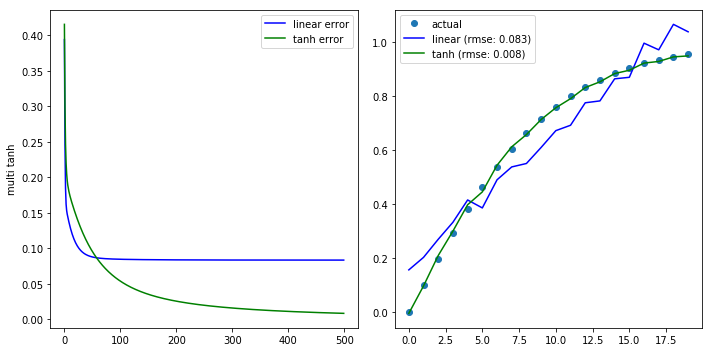

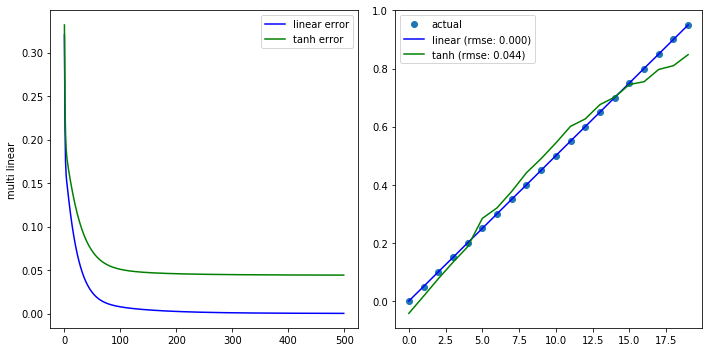

In [14]:
X = (np.arange(20) * 0.1).reshape((-1,1))
Xmulti = np.random.rand(20, 5) # add noise
Xmulti[:, 0] = X[:, 0] # 
TmultiTanh = np.tanh(Xmulti[:, 0:1]) # use first row to generate data
TmultiLinear = Xmulti[:, 0:1] # use first row to generate data
test('multi tanh', Xmulti, TmultiTanh)
test('multi linear', Xmulti, TmultiLinear/2) # /2 so tanh has a chance to fit it

After seeing the results of the first graph, I repeated the test with the linear model.

This one did something I wasn't expecting. The linear model doesn't look linear.

These graphs are different since it uses a multidimensional input instead of a vector. I added random noise in the extra dimensions, and the output depends only on the first row. A good model should figure that out and ignore the noise. $\tanh$ does exactly that, and in the end fits the data perfectly. However, the linear model uses the noise to instead fit better than it would.

What I didn't expect, the linear model used the noise to stop being linear and actually fit the data better. From above, the linear model has a RSME of 0.125 fitting tanh models, but this one has much less. We know it's over-fitting, so it might not be useful, but it'd be interesting to see what other models can benefit from added random noise for the model to use at its disposal (e.g., simulating noise).

In the second experiment, the actual model is linear, so linear is a perfect fit. Now, tanh can't fit perfectly, but it still is capable of deviating from it's shape to fit linear pretty well.

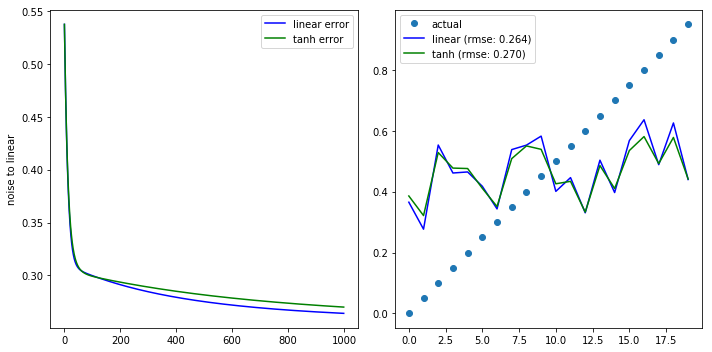

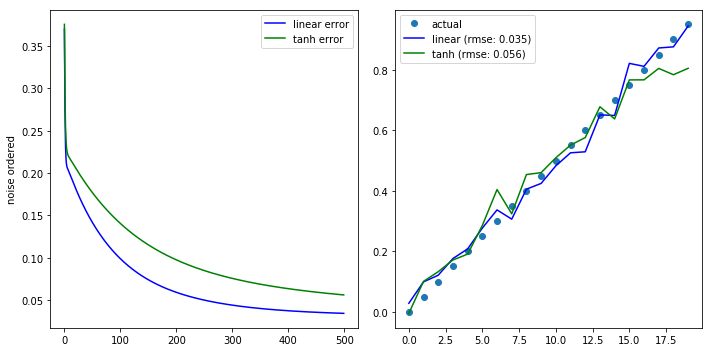

In [15]:
Xmulti = np.random.rand(20, 5)
Tmulti = (np.arange(20)*.05).reshape(-1, 1)
test('noise to linear', Xmulti, Tmulti, eta=0.001, trials=1000)
order = np.argsort(np.mean(Xmulti, axis=1)).reshape(-1)
test('noise ordered', Xmulti[order], Tmulti)

In the first graph, I fed it pure noise hoping it would overfit and be a good model, but I actually have no idea what's happening. Both models are initialized with different but random weights, yet they both converge to the same wrong answer. I wasn't expecting them to converge to the solution, but I especially wasn't expecting them to look the same.

The second graph shows what happens when you sort the noise by its mean, so it's kind of in ascending order. All the model has to do is pick up on this fact. It generally does fit the data, so I think it was successful, interestingly. At least, the RSME is smaller.

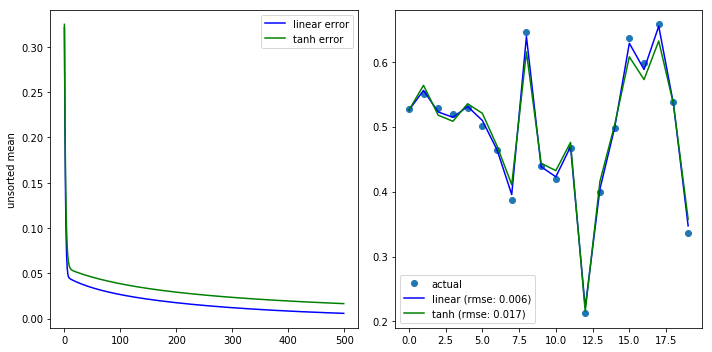

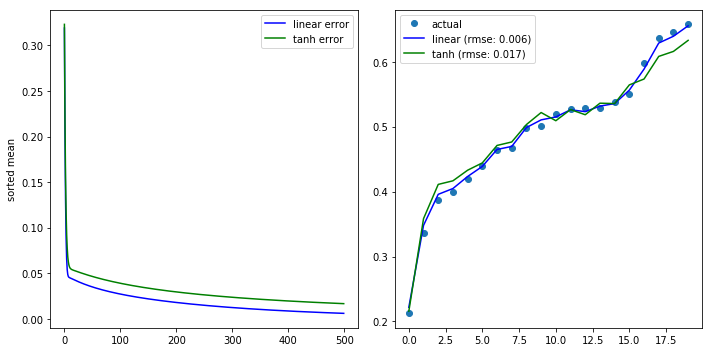

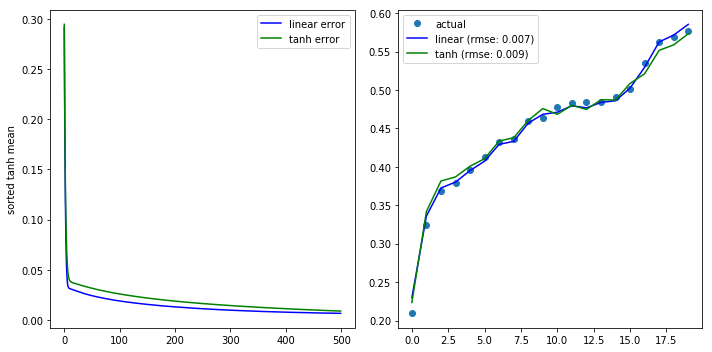

In [16]:
X = np.random.rand(20, 5)
T = np.mean(X, axis=1).reshape(-1, 1)
order = np.argsort(T, axis=0).reshape(-1)
test('unsorted mean', X, T)
test('sorted mean', X[order], T[order])
test('sorted tanh mean', X[order], np.tanh(T[order]))

This model actually makes the target be the mean of noise. Three observations here:
* Even though the data isn't continuous, the models are smart enough to not care. Both fit very nicely.
* Taking a mean is a linear combination, and therefore the linear model is capable of fitting perfectly. My trainer does converge to this solution, which is good.
* In the third graph, we can see tanh even converges to this perfectly.

## Grading

Your notebook will be run and graded automatically.  Test this grading process by first downloading [A1grader.tar](http://www.cs.colostate.edu/~anderson/cs445/notebooks/A1grader.tar) and extract `A1grader.py` from it. Run the code in the following cell to demonstrate an example grading session.  You should see a perfect execution score of 80 out of 80 points if your functions are defined correctly. The remaining 20 points will be based on the results you obtain from the energy data and on your discussions.

For the grading script to run correctly, you must first name this notebook as 'Lastname-A1.ipynb' with 'Lastname' being your last name, and then save this notebook.

A different, but similar, grading script will be used to grade your checked-in notebook.  It will include additional tests.  You need not include code to test that the values passed in to your functions are the correct form.  

((-3.3196624548495604, 0.37837942676112085),
 0.17345236816737344,
 0.17345235565234787)

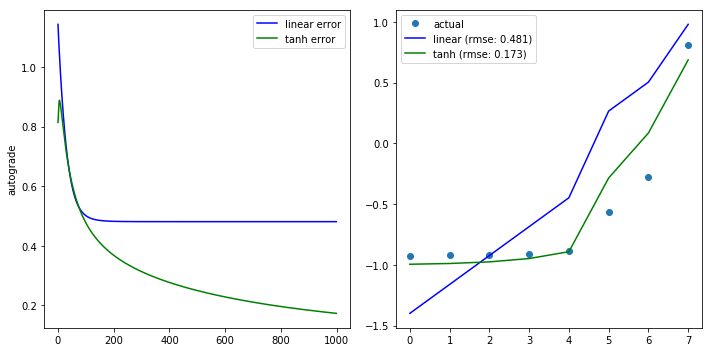

In [17]:
X = np.array([1, 2, 3, 4, 5, 8, 9, 11]).reshape((-1, 1))
T = (((X - 5) * 0.05 +  (X * 0.2) **5) / 5.0 - 5.5) / 6
_, (tanh_model, err), _ = test('autograde', X, T, eta=0.01, trials=1000, give_models=True)

soln_model = np.array([[-3.31966245], [ 0.37837943]])
soln_rmse = rmse(use_tanh(soln_model, X), T)
my_rmse = rmse(use_tanh(tanh_model, X), T)
tuple((i for i in tanh_model[:, 0])),soln_rmse, my_rmse

In [18]:
%run -i "A1grader.py"


======================= Code Execution =======================

Extracting python code from notebook named 'Wilson-A1.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing
  X = np.array([1, 2, 3, 4, 5, 8, 9, 11]).reshape((-1, 1))
  T = (((X - 5) * 0.05 +  (X * 0.2) **5) / 5.0 - 5.5) / 6
  w, errors = train_linear(X, T, 0.01, 1000)

--- 15/15 points. Returned correct values.

Testing
  prediction = use_linear(w, X)

--- 15/15 points. Returned correct values.

Testing
  rmse_error = rmse(prediction, T)

--- 15/15 points. Returned correct values.

Testing
  w, errors = train_tanh(X, T, 0.01, 1000)

--- 15/15 points. Returned correct values.

Testing
  prediction = use_tanh(w, X)

--- 15/15 points. Returned correct values.

a1 Execution Grade is 75 / 75

 Remaining 25 points will be based on your text describing the derivation of gradients, explanations of code, and plots.

a1 FINAL GRADE is   / 100

a1 EXTRA CRED

<Figure size 432x288 with 0 Axes>

## Extra Credit

Define two new functions to handle the logistic, or sigmoid, function model, 

$$ \Yv = \frac{1}{1 + e^{- \Xv \wv}} $$

By this point, we can jump to this step:

$$\wv_{k+1} = \wv_k - \eta \nabla_{\wv_k} E(X)$$
and 

$$
\nabla_{\wv_k} E(X) = -2 \big(\frac{\partial }{\partial \wv_k} \frac{1}{1 + e^{- \Xv \wv_k}} \big)^T (\Tv-\Yv).
$$

Then, it follows that:

$$
\begin{align*}
\frac{\partial}{\partial \wv} \frac{1}{1 + e^{- \Xv \wv}} &= \frac{\partial}{\partial \wv}\big(1+e^{-\Xv\wv}\big)^{-1} \\
&= diag\Big(\big(1+e^{-\Xv\wv}\big)^{-2}e^{-\Xv\wv}\Big)\Xv \\
&= diag\big(\Yv^2 e^{-\Xv\wv}\big)\Xv \\
&= diag\big(\Yv^2 e^{-\Xv\wv} - \Yv^2 + \Yv^2 \big)\Xv & \text{(we want it in terms of only $\Yv$)} \\
\end{align*}
$$

After looking up the actual derivative, I see how we can get it in terms of only $\Yv$, which I like more. 

$$
\begin{align*}
\frac{\partial}{\partial \wv} \frac{1}{1 + e^{- \Xv \wv}} &= diag\big(\Yv^2 e^{-\Xv\wv}\big)\Xv \\
&= diag\big(\Yv^2 e^{-\Xv\wv} - \Yv^2 + \Yv^2 \big)\Xv \\
&= diag\big(\Yv^2 (1 + e^{-\Xv\wv} - 1) \big)\Xv \\
&= diag\big(\Yv^2 (1 + e^{-\Xv\wv} - 1) \big)\Xv \\
&= diag\big(\Yv^2 (\Yv^{-1} - 1) \big)\Xv & \text{(piecewise inverse not matrix inverse)} \\
&= diag\big(\Yv^1 (\Yv^0 - \Yv) \big)\Xv \\
&= diag\big(\Yv (\mathbf{1} - \Yv) \big)\Xv & \text{piecewise multiplication)} \\
\end{align*}
$$


In python:

    Y*(1-Y)*X

In [19]:
def train_sigmoid(X, T, learning_rate, number_of_iterations):
    """
    * `X` is a two-dimensional matrix (`np.array`) with each row containing one data sample
    * `T` is a two-dimensional matrix of one column containing the target values for each sample in `X`. `X.shape[0]` is equal to `T.shape[0]`
    * `learning_rate` is the factor multiplying the negative derivative
    * `number_of_iterations` is the number of update steps to take
    * `model` is the two-dimensional matrix of one column containing the resulting weights
    """
    def gradientf(X, Y, model, use_modelf):
        return Y*(1-Y)*X
    return train_model(X, T, learning_rate, number_of_iterations, use_sigmoid, gradientf)

def sigmoid(x):
    return 1/(1+np.exp(-x))
    
def use_sigmoid(model, X):
    X = np.insert(X, 0, 1, axis=1)
    return sigmoid(X@model)

In [20]:
def test_sigmoid(title, X, T, eta=0.01, trials=10000):
    sigmoid_model = train_sigmoid(X, T, eta, trials)
    test(title, X, T, 
         other_model=sigmoid_model, other_use=use_sigmoid, other_label='sigmoid',
         eta=eta, trials=trials)

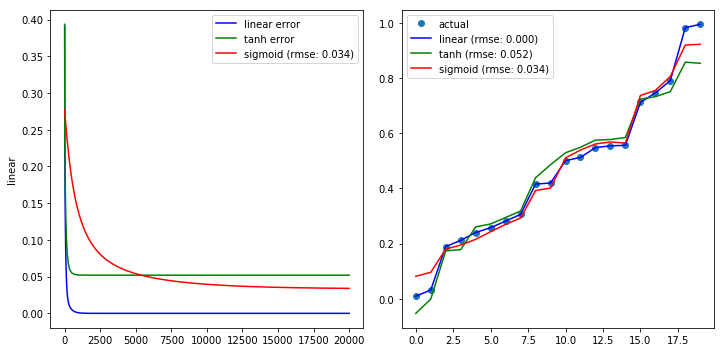

In [21]:
X = np.random.rand(20, 5)
T = np.mean(X[:, 0:1], axis=1)
order = np.argsort(T, axis=0).reshape(-1) # getting the arg sort of T
test_sigmoid('linear', X[order], X[order, 0:1], trials=20000)

Sigmoid converges slower, but it does better than $\tanh$! Linear of course does perfectly.

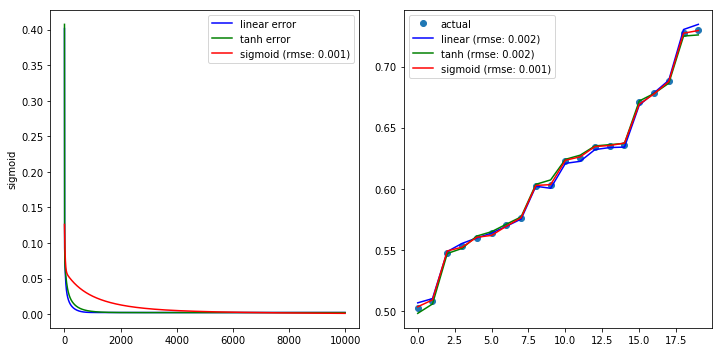

In [22]:
test_sigmoid('sigmoid', X[order], sigmoid(X[order, 0:1]))

They all seem to fit sigmoid really well. Interestingly, sigmoid doesn't do perfectly. This could mean an error in my math..

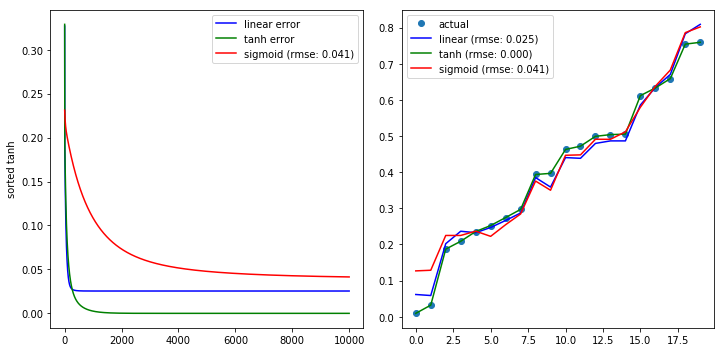

In [23]:
test_sigmoid('sorted tanh', X[order], np.tanh(X[order, 0:1]))

It fits $\tanh$ but seems to still be the worst performer.

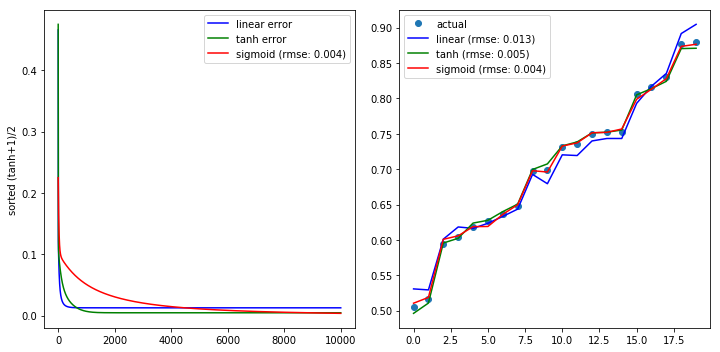

In [24]:
test_sigmoid('sorted (tanh+1)/2', X[order], (np.tanh(X[order, 0:1])+1)/2)

Here is a sample of it fitting different models. It fits the sigmoid model perfectly, which is good. It roughly fits the linear and tanh models too, so it seems to be functioning. Although, it's worth pointing out that sigmoid seems to converge much slower than the others.

This function and tanh look pretty similar, so I don't know how useful it is to experiment with this more than I already have with tanh.

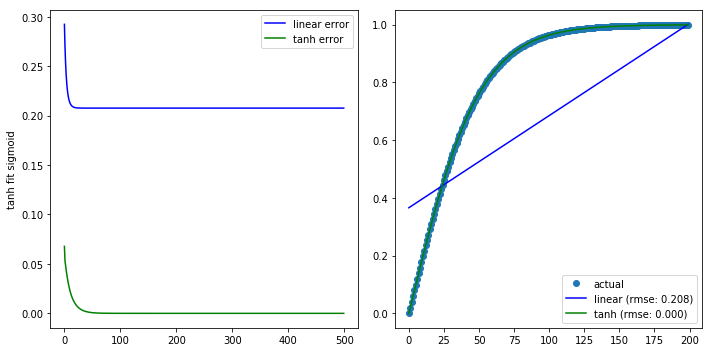

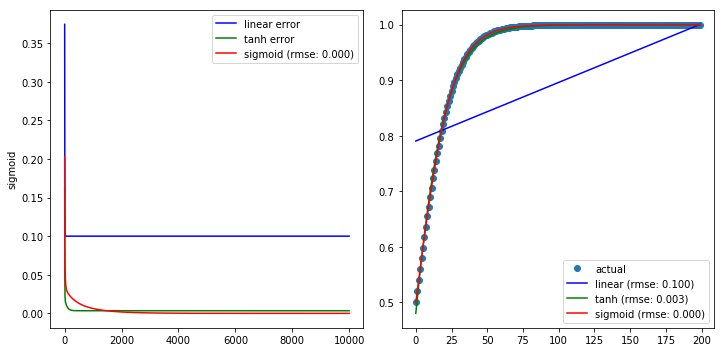

In [25]:
X = np.arange(200).reshape(-1, 1)/25
test('tanh fit sigmoid', X, 2*sigmoid(X)-1)
test_sigmoid('sigmoid', X, (np.tanh(X)+1)/2)

Here we see here that $2 sigmoid(x)-1 = \tanh(2 x)$
$$
\begin{align*}
2 sigmoid(x)-1 &= \frac{2}{1+e^{-x}}-1 \\
&= \frac{2}{1+e^{-x}} - \frac{1+e^{-x}}{1+e^{-x}} \\
&= \frac{2 - 1 - e^{-x}}{1+e^{-x}} \\
&= \frac{1 - e^{-x}}{1+e^{-x}} \\
&= \frac{e^{x/2} - e^{-x/2}}{e^{x/2} + e^{-x/2}} \\
&= \tanh\big(\frac{z}{2}\big)
\end{align*}
$$

The weights converge to the $\frac{z}{2}$, and then the models fit each other exactly after the transformation. That is why we see a RSME of $0.00$ for $200$ samples. We should expect the weight matrix to be $0.5$.

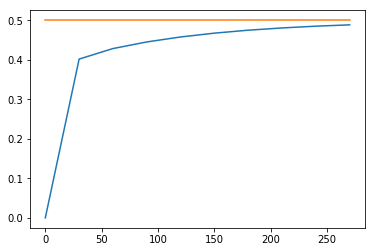

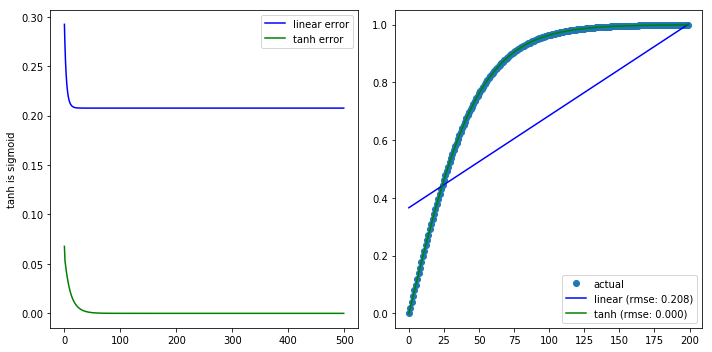

In [26]:
X = np.arange(200).reshape(-1, 1)/25
iters = []
x = []
for i in range(10):
    iter = i*30
    model = train_tanh(X, 2*sigmoid(X)-1, 0.001, iter)
    iters.append(iter)
    x.append(model[0][1])

plt.plot(iters, x)
plt.plot(iters, [0.5 for _ in x]);
test('tanh is sigmoid', X, 2*sigmoid(X)-1)

You can see after about 200 iterations, it converges to 0.5 like we expected. 